In [4]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

from string import split,strip

from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.tree import RandomForest, RandomForestModel

from pyspark.mllib.util import MLUtils

In [5]:
#define feature names
feature_text='lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb'
features=[strip(a) for a in split(feature_text,',')]
print len(features),features

28 ['lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude', 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']


In [6]:
# Read the file into an RDD
# If doing this on a real cluster, you need the file to be available on all nodes, ideally in HDFS.
path='HIGGS.csv'
inputRDD=sc.textFile(path)
#inputRDD.take(5)

In [17]:
# Transform the text RDD into an RDD of LabeledPoints
#input_sampled = inputRDD.sample(False,0.001)
Data=inputRDD.map(lambda line: [float(strip(x)) for x in line.split(',')])\
                .map(lambda x : LabeledPoint (x[0] , x[1:] ))
Data.first()

LabeledPoint(1.0, [0.869293212891,-0.635081827641,0.22569026053,0.327470064163,-0.689993202686,0.754202246666,-0.24857313931,-1.09206390381,0.0,1.37499213219,-0.653674185276,0.930349111557,1.10743606091,1.13890433311,-1.57819831371,-1.0469853878,0.0,0.65792953968,-0.0104545699432,-0.0457671694458,3.10196137428,1.35376000404,0.979563117027,0.978076159954,0.920004844666,0.721657454967,0.988750934601,0.876678347588])

In [18]:
#input_sampled = inputRDD.sample(False,0.01, seed=255)
Data1=Data.sample(False,0.01).cache()
(trainingData,testData)=Data1.randomSplit([0.7,0.3])

In [19]:
counts=testData.map(lambda lp:(lp.label,1)).reduceByKey(lambda x,y:x+y).collect()
counts.sort(key=lambda x:x[1],reverse=True)
counts

[(1.0, 17636), (0.0, 15787)]

In [31]:
from time import time
errors={}
categoricalFeaturesInfo = {}
for depth in [1,3,6,10]:
    start=time()
    model=GradientBoostedTrees.trainClassifier(trainingData,categoricalFeaturesInfo,numIterations=10,maxDepth=depth)
    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        Predicted=model.predict(data.map(lambda x: x.features))
        LabelsAndPredictions=data.map(lambda lp: lp.label).zip(Predicted)
        Err = LabelsAndPredictions.filter(lambda (v,p):v != p).count()/float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
print errors

1 {'test': 0.38461538461538464, 'train': 0.3829621149042465} 93 seconds
3 {'test': 0.3242677198336475, 'train': 0.3261604912572856} 109 seconds
6 {'test': 0.29841725757711757, 'train': 0.28966746461282267} 173 seconds
10 {'test': 0.3032342997337163, 'train': 0.1945774354704413} 828 seconds
{1: {'test': 0.38461538461538464, 'train': 0.3829621149042465}, 10: {'test': 0.3032342997337163, 'train': 0.1945774354704413}, 3: {'test': 0.3242677198336475, 'train': 0.3261604912572856}, 6: {'test': 0.29841725757711757, 'train': 0.28966746461282267}}


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


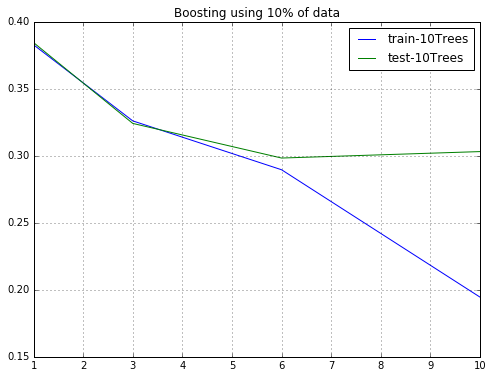

In [32]:
B10 = errors
# Plot Train/test accuracy vs Depth of trees graph
%pylab inline
from plot_utils import *
make_figure([B10],['10Trees'],Title='Boosting using 10% of data')

In [33]:
from time import time
categoricalFeaturesInfo = {}
errors={}
for depth in [1,3,6,10,15,20]:
    start=time()
    model = RandomForest.trainClassifier(trainingData,2,categoricalFeaturesInfo,numTrees=10,maxDepth=depth)
    #print model.toDebugString()
    errors[depth]={}
    dataSets={'train':trainingData,'test':testData}
    for name in dataSets.keys():  # Calculate errors on train and test sets
        data=dataSets[name]
        predictions = model.predict(data.map(lambda x: x.features))
        labelsAndPredictions = data.map(lambda lp: lp.label).zip(predictions)
        Err = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(data.count())
        errors[depth][name]=Err
    print depth,errors[depth],int(time()-start),'seconds'
print errors

1 {'test': 0.40615743649582625, 'train': 0.40618495004163196} 34 seconds
3 {'test': 0.37728510307273433, 'train': 0.3763140091590341} 36 seconds
6 {'test': 0.32534482242766954, 'train': 0.32026696502914237} 64 seconds
10 {'test': 0.3068246417137899, 'train': 0.2702955870108243} 150 seconds
15 {'test': 0.30646560751578256, 'train': 0.1340679641965029} 597 seconds
20 {'test': 0.31684767974149536, 'train': 0.03480172772689426} 1559 seconds
{1: {'test': 0.40615743649582625, 'train': 0.40618495004163196}, 3: {'test': 0.37728510307273433, 'train': 0.3763140091590341}, 6: {'test': 0.32534482242766954, 'train': 0.32026696502914237}, 10: {'test': 0.3068246417137899, 'train': 0.2702955870108243}, 15: {'test': 0.30646560751578256, 'train': 0.1340679641965029}, 20: {'test': 0.31684767974149536, 'train': 0.03480172772689426}}


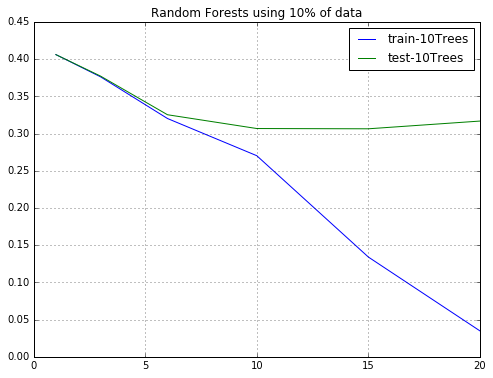

In [34]:
RF_10trees = errors
make_figure([RF_10trees],['10Trees'],Title='Random Forests using 10% of data')

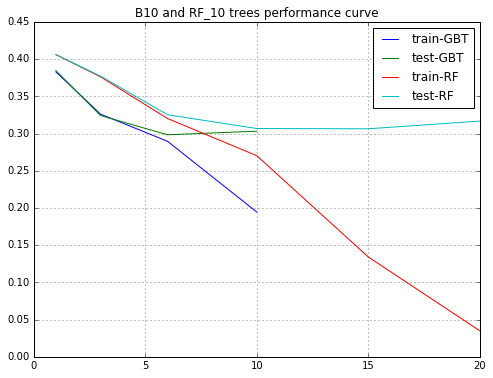

In [35]:
make_figure([B10,RF_10trees],['GBT','RF'],Title='B10 and RF_10 trees performance curve')